In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
data = pd.read_csv("../data/main/training.csv",index_col=0)
data.head()

/home/bilguun/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,RECORD_DATE,BUS_ID,BUSROUTE_ID,BUSSTOP_ID,BUSSTOP_SEQ,TIMESTAMP
index,,,,,,
0,2020-01-06 07:00:00,325819008,11100360,388,21,1578294000
1,2020-01-06 07:00:00,451509115,11100480,112,9,1578294000
2,2020-01-06 07:00:00,235501055,11100500,374,9,1578294000
3,2020-01-06 07:00:00,145010001,11100330,331,30,1578294000
4,2020-01-06 07:00:01,421733004,11100620,51,29,1578294001


In [3]:
train = data.sort_values("TIMESTAMP").iloc[:int(len(data)*0.8)].sort_values(["BUS_ID","TIMESTAMP"])
test = data.sort_values("TIMESTAMP").iloc[int(len(data)*0.8):].sort_values(["BUS_ID","TIMESTAMP"])
del data

In [4]:
train.to_csv("../data/full/train.csv")
test.to_csv("../data/full/eval.csv")

In [9]:
import os
#os.mkdir("../data/testL")
train[int(len(train)*0.8):].to_csv("../data/testL/train.csv")
test[int(len(test)*0.8):].to_csv("../data/testL/eval.csv")

In [5]:
import dataHandler as dh
import evaluators as ev

In [6]:
trY = dh.calcTimeDelta(train)
teY = dh.calcTimeDelta(test)

def featureGen(X):
    a = X[['BUS_ID', 'BUSROUTE_ID', 'BUSSTOP_ID', 'BUSSTOP_SEQ']]
    d = X[['BUSSTOP_ID', 'BUSSTOP_SEQ']].shift(-1).fillna(method="ffill")
    d.columns = ['DEST_BUSSTOP_ID', 'DEST_BUSSTOP_SEQ']
    return pd.concat([a,d],axis=1)
trX = featureGen(train)
teX = featureGen(test)

del train
del test

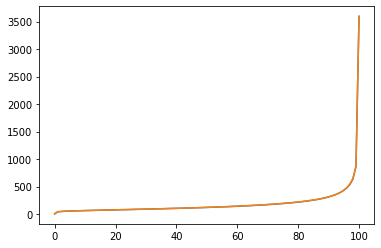

In [13]:
pd.Series([trY.quantile(i/100) for i in range(0,101)]).plot()
pd.Series([teY.quantile(i/100) for i in range(0,101)]).plot()

In [16]:
teY[teY>500].pl

index
2676941     579.0
2702465    1602.0
2786290     706.0
2819297     722.0
2823304     722.0
2834851     513.0
2836902     555.0
2839134     879.0
2850338     694.0
2860799     570.0
2864740     831.0
2870618     920.0
2654929     680.0
2686983    1058.0
2703001     715.0
2769841     620.0
2780369     536.0
2806588     746.0
2810993     542.0
2846028     540.0
2848067    1508.0
2860692     554.0
2862974     574.0
2867085     520.0
2899819    1861.0
3106415     542.0
3142118     888.0
3186626     517.0
3189804    1379.0
3195541    1402.0
            ...  
3170858    1424.0
3181629     796.0
3184050    1262.0
3192328     669.0
3194491    1284.0
2593846     915.0
2604468     580.0
2608478     606.0
2851169     525.0
2853385     764.0
2940847    1575.0
2986596     588.0
2992483     635.0
3013032    1333.0
2581992     539.0
2584066    1146.0
2619198     533.0
2675011     599.0
2694832     528.0
2714233     597.0
2734342     627.0
2742620     962.0
2754037     515.0
2764063     606.0
2809

## Regressor analysis

In [6]:
minLimit = 2

def predictTd(X, stats):
    featureCombinations = pd.DataFrame(getkeys(X))
    featureCombinations.columns = ["feature"]
    preds = pd.merge(left=featureCombinations, 
                     right=stats.reset_index(), 
                     how='left', left_on="feature", right_on="feature")
    for c in ["mean","std","min","max","count"]:
        preds[c] = preds[c].fillna(stats[c].mean())
    preds.index = X.index
    return preds

def predictTs(tsHidden, predTd, conf):
    confCumSum = conf.cumsum()
    prevVal = None
    unkIdx = []
    lastKnownIdx = None
    for i, v in tqdm(list(tsHidden.iteritems())):
        if np.isnan(v):
            tsHidden[i] = prevVal + predTd[i]
            prevVal = tsHidden[i]
            unkIdx.append(i)
        else:
            if len(unkIdx) > 0:
                if i in predTd.index:
                    z = confCumSum[lastKnownIdx]
                    diff = (tsHidden[i] - tsHidden[unkIdx[-1]] - predTd[i]) / (confCumSum[i] - z)
                    for j in unkIdx:
                        tsHidden[j] += diff * (confCumSum[j] - z)
            prevVal = tsHidden[i]
            lastKnownIdx = i
            unkIdx = []

    return tsHidden

def mae(pred, real):
    return np.mean(np.abs(pred - real))

In [7]:
columns = ["BUSSTOP_ID", "DEST_BUSSTOP_ID"]

def getkeys(X):
    keys = X[columns[0]].astype(str)
    for col in columns[1:]:
        keys += "-" + X[col].astype(str)
    return keys

def getstats(X, Y):
    featureCombinations = getkeys(X)
    tmp = pd.concat([featureCombinations, Y], axis=1).dropna()
    tmp.columns = ["feature", "time"]
    group = tmp.groupby("feature")
    stats = pd.concat([
            group.mean(),
            group.std(),
            group.min(),
            group.max(),
            group.count()
        ], axis=1)
    stats.columns = ["mean","std","min","max","count"]
    stats["conf1"] = 1.95 * stats["std"] / np.sqrt(stats["count"])
    stats["conf2"] = group.apply(lambda data: np.mean(np.abs(data["time"]-data["time"].mean())))
    return stats

trStats = getstats(trX, trY)
teStats = getstats(teX, teY)

In [8]:
trStats.describe()

,mean,std,min,max,count,conf1,conf2
count,3528.000000,2275.000000,3528.000000,3528.000000,3528.000000,2275.000000,3528.000000
mean,513.260388,128.416049,431.866497,947.888322,709.496882,85.839690,56.611243
std,535.136278,172.947915,536.474964,785.687468,1846.228061,194.977782,110.569598
min,34.314828,0.707107,3.000000,61.000000,1.000000,0.401413,0.000000
25%,153.967613,30.958608,76.000000,344.000000,1.000000,2.727944,0.000000
50%,316.725000,65.935155,221.000000,689.500000,3.000000,12.032491,16.589057
75%,684.750000,154.149803,576.250000,1302.250000,667.000000,70.108062,59.986810
max,3566.000000,1700.591809,3566.000000,3596.000000,19836.000000,2344.875000,1202.500000


In [11]:
trPredTd = predictTd(trX, trStats)
tePredTd = predictTd(teX, trStats)

In [91]:
trErrorStats=getstats(trX, (trY - trPredTd["mean"])[trY.index])

In [92]:
trErrorStats.describe()

,mean,std,min,max,count,conf1,conf2
count,3.528000e+03,2275.000000,3528.000000,3528.000000,3528.000000,2275.000000,3528.000000
mean,-1.742100e-15,128.416049,-81.393891,434.627934,709.496882,85.839690,56.611243
std,1.184375e-13,172.947915,130.446624,713.602275,1846.228061,194.977782,110.569598
min,-3.307015e-12,0.707107,-1312.000000,0.000000,1.000000,0.401413,0.000000
25%,0.000000e+00,30.958608,-101.217462,0.000000,1.000000,2.727944,0.000000
50%,0.000000e+00,65.935155,-36.771242,76.000000,3.000000,12.032491,16.589057
75%,0.000000e+00,154.149803,0.000000,557.529639,667.000000,70.108062,59.986810
max,1.163282e-12,1700.591809,0.000000,3481.415416,19836.000000,2344.875000,1202.500000


In [93]:
trPredErrorTd=predictTd(trX, trErrorStats)

In [22]:
def confErrorCorrelation():
#     z = trPredTd["conf2"] / np.sqrt(trPredTd["count"])
#     x = tePredTd["conf2"] / np.sqrt(tePredTd["count"])
    z = trPredTd["mean"] / np.sqrt(trPredTd["count"])
    x = tePredTd["mean"] / np.sqrt(tePredTd["count"])
    for i in range(1,11):
        n = z.quantile(i/10)
        confTr = z < n
        confTe = x < n
        print(f"{i/10}\t{n}\t{mae(trPredTd['mean'][confTr],trY)} \t {mae(tePredTd['mean'][confTe],teY)}")

In [35]:
z = trPredTd["conf2"] / np.sqrt(trPredTd["count"])

In [37]:
trickyI=z>z.quantile(0.7)

In [86]:
tr=trY - trPredTd["mean"]

In [61]:
err=tr[trY.index].abs().sort_values()

In [62]:
err.quantile(0.8)

66.85325648414988

In [65]:
trXY=trX.loc[trY.index]

In [67]:
highError=trXY[err>66.85]

/home/bilguun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [69]:
highError["Y"]=trY[err>66.85]

/home/bilguun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
highError["Pred"]=err[err>66.85]

/home/bilguun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
highError.sort_values(["Y"])

,BUS_ID,BUSROUTE_ID,BUSSTOP_ID,BUSSTOP_SEQ,DEST_BUSSTOP_ID,DEST_BUSSTOP_SEQ,Y,Pred
index,,,,,,,,
2495182,372119016,11100650,379,16,380.0,17.0,3.0,138.501732
80314,494612058,11400056,380,27,379.0,28.0,4.0,107.790620
2543779,65413254,11400056,380,27,379.0,28.0,5.0,106.790620
195674,65413254,11400056,380,27,379.0,28.0,6.0,105.790620
1668909,145010002,11100330,303,43,305.0,44.0,6.0,185.448661
570904,892612077,11400056,380,27,379.0,28.0,7.0,104.790620
1891732,453309133,11100020,164,22,163.0,23.0,7.0,180.552994
857581,494612058,11400056,380,27,379.0,28.0,7.0,104.790620
1729934,494612058,11400056,380,27,379.0,28.0,7.0,104.790620


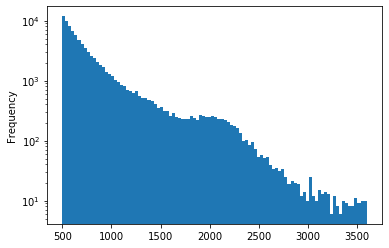

In [17]:
fig, ax = plt.subplots()
trY[trY>500].plot.hist(ax=ax,bins=100)
ax.set_yscale('log')

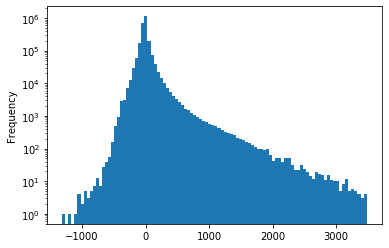

In [95]:
fig, ax = plt.subplots()
(trY - trPredTd["mean"])[trY.index].plot.hist(ax=ax,bins=100)
ax.set_yscale('log')

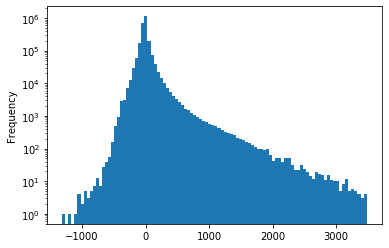

In [96]:
fig, ax = plt.subplots()
(trY - trPredTd["mean"] - trPredErrorTd["mean"])[trY.index].plot.hist(ax=ax,bins=100)
ax.set_yscale('log')

In [99]:
trPredErrorTd["mean"].describe()

count    2.576203e+06
mean    -1.412828e-14
std      3.773393e-13
min     -3.307015e-12
25%     -4.167651e-14
50%     -1.693659e-15
75%      5.622279e-14
max      1.163282e-12
Name: mean, dtype: float64

In [18]:
import pickle

In [20]:
z=pickle.load(open("../lol","rb"))

In [22]:
indices=z[0]
vals=z[1]

In [24]:
journeys = [vals[i] - vals[i[0]] for i in indices]

In [39]:
z=pd.Series(len(i) for i in indices)
z.describe()

count    2273.000000
mean        1.064232
std         0.264227
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
dtype: float64

In [41]:
len([len(i) for i in indices if len(i) == 1]) / 2273

0.9392872855257369

In [36]:
vals.head()

index
2816644    1579279101
2817356    1579279253
2818801    1579279560
2820010    1579279832
2658316    1579247608
Name: TIMESTAMP, dtype: int64

In [38]:
back_transaction=vals.diff(1)
forward_transaction=-vals.diff(-1)

In [42]:
t=pd.DataFrame([(back_transaction[i[0]],forward_transaction[i[0]]) for i in indices if len(i) == 1])

In [44]:
t.describe()

,0,1
count,2135.000000,2135.000000
mean,356.104918,369.924122
std,138.973369,133.631282
min,54.000000,39.000000
25%,244.500000,264.500000
50%,367.000000,371.000000
75%,470.500000,487.000000
max,599.000000,599.000000


In [46]:
(t[0] - t[0].mean()).abs().mean()

117.61007716819596

In [47]:
356.1+369.9

726.0

In [48]:
726/2

363.0

In [ ]:
pd.Series(list(range(10))).rolling(2).sum()